In [1]:
import json
from pathlib import Path

import matplotlib.pyplot as plt

HOME = str(Path('~').expanduser())

FIGSIZE = (15, 9)
AXIS_LABEL_FONT_SIZE = 40
TICKS_FONT_SIZE = 30
LINE_SIZE = 6
LEGEND_FONT_SIZE = 35

In [2]:
def fall_times(jsonfile, log_start=350000, n_files=10, file_indx=-1):
    all_delays = {}
    f = open(jsonfile, 'r')
    data = json.load(f)
    f.close()
    
    for file in data:
        if file_indx!= -1 and f'{file_indx}.txt' not in file:
            continue
        distype, _, n_shards, _, _ = file.split()
        pv, b = data[file]
        delays = []
        
        for shard in pv:
            point_exits = False
            for indx, (i, p, t) in enumerate(pv[shard]):
                if p == -1 and i > b[shard]:
                    if pv[shard][indx-1][1] != -1:
                        delays.append(t - log_start)
                    else:
                        delays.append(t - log_start) 
                    point_exits = True
                    break
            if not point_exits:
                i, p, t = pv[shard][-1]
                delays.append(t - log_start)
                print(file, shard)
                
        delays.sort()
        if (distype, n_shards) in all_delays:
            all_delays[(distype, n_shards)] = [x + y for x, y in zip(all_delays[(distype, n_shards)], delays)]
        else:
            all_delays[(distype, n_shards)] = delays

    for d in all_delays:
        all_delays[d] = [x / n_files for x in all_delays[d]]
    return all_delays


ad = fall_times('results.json')

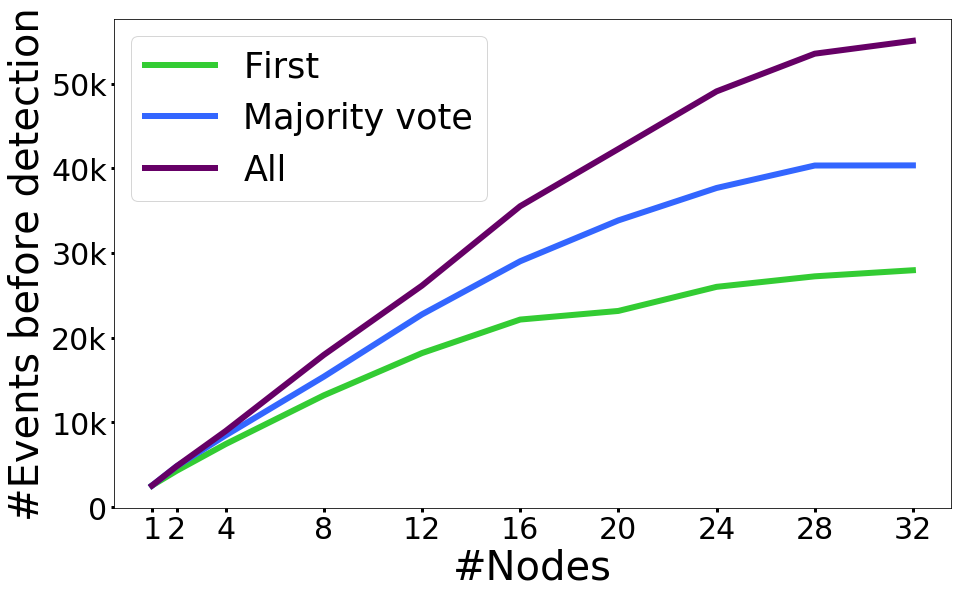

In [20]:
# Decision making

shards = [1, 2, 4, 8, 12, 16, 20, 24, 28, 32]
yticks = [i for i in range(0, 60001, 10000)]

fig, ax = plt.subplots(figsize=FIGSIZE)
ax.set_xlabel('#Nodes', fontsize=AXIS_LABEL_FONT_SIZE)
ax.set_ylabel('#Events before detection',           fontsize=AXIS_LABEL_FONT_SIZE)
ax.set_xticks(shards)
ax.set_yticks(yticks)
ax.set_yticklabels(['0', '10k', '20k', '30k', '40k', '50k', '60k'])
ax.tick_params(width=3, labelsize=TICKS_FONT_SIZE)

ax.plot(shards, [ad[('round', str(i))][0] for i in shards],
        label='First',
        linewidth=LINE_SIZE,
        color='#33cc33')
ax.plot(shards, [ad[('round', str(i))][len(ad[('round',str(i))]) // 2] for i in shards],
        label='Majority vote',
        linewidth=LINE_SIZE,
        color='#3366ff')
ax.plot(shards, [ad[('round', str(i))][-1] for i in shards],
        label='All',
        linewidth=LINE_SIZE,
        color='#660066')

ax.legend(fontsize=LEGEND_FONT_SIZE)
fig.savefig(HOME + '/decision_making.png', bbox_inches='tight')
plt.show()

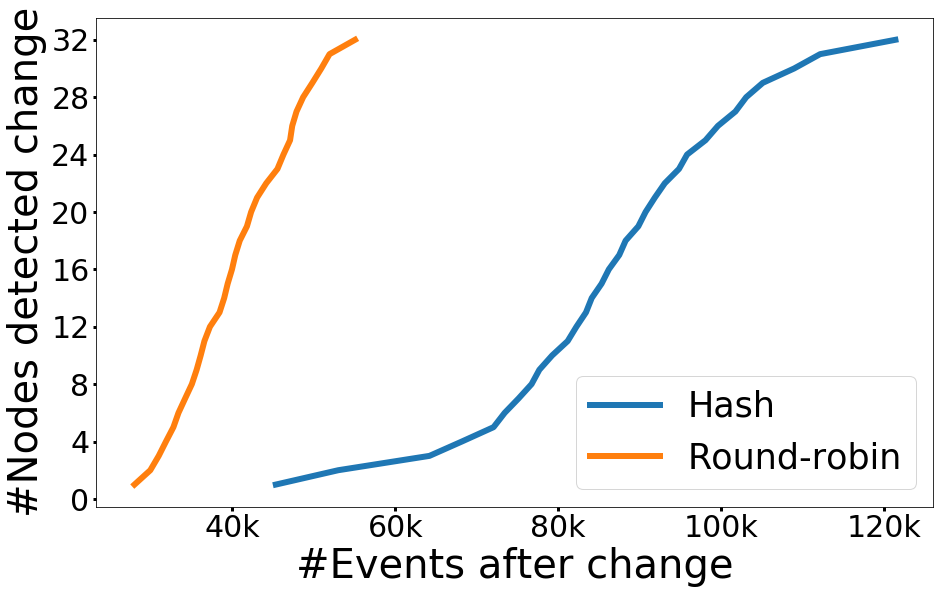

In [13]:
# Decision speed

n_shards = 32
xticks = [i for i in range(40000, 120001, 20000)]
yticks = [0, 4, 8, 12, 16, 20, 24, 28, 32]
xticklabels = ['40k', '60k', '80k', '100k', '120k']

fig, ax = plt.subplots(figsize=FIGSIZE)
ax.set_xlabel('#Events after change',          fontsize=AXIS_LABEL_FONT_SIZE)
ax.set_ylabel('#Nodes detected change', fontsize=AXIS_LABEL_FONT_SIZE)
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.set_yticks(yticks)
ax.tick_params(width=3, labelsize=TICKS_FONT_SIZE)

ax.plot(ad[('hash', str(n_shards))] , range(1, n_shards + 1),
        label='Hash',
        linewidth=LINE_SIZE)
ax.plot(ad[('round', str(n_shards))], range(1, n_shards + 1),
        label='Round-robin',
        linewidth=LINE_SIZE)
ax.legend(loc=4, fontsize=LEGEND_FONT_SIZE)

fig.savefig(HOME + '/detection_rate.png', bbox_inches='tight')
plt.show()

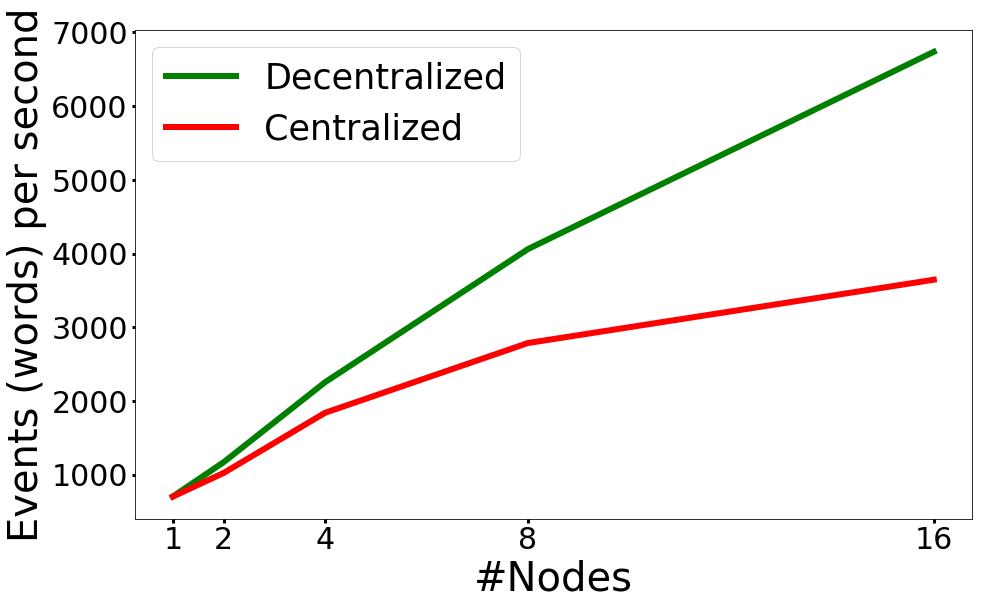

In [11]:
# Throughput

shuffle = [702, 1167, 2253, 4060, 6738]
merge = [701, 1021, 1838, 2785, 3644]

xticks = [1, 2, 4, 8, 16]
yticks = [i for i in range(1000, 7001, 1000)]

fig, ax = plt.subplots(figsize=FIGSIZE)
ax.set_xlabel('#Nodes',  fontsize=AXIS_LABEL_FONT_SIZE)
ax.set_ylabel('Events (words) per second', fontsize=AXIS_LABEL_FONT_SIZE)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.tick_params(width=3, labelsize=TICKS_FONT_SIZE)

ax.plot(xticks, shuffle, linewidth=LINE_SIZE, label='Decentralized', color='green')
ax.plot(xticks, merge,   linewidth=LINE_SIZE, label='Centralized',   color='red')

ax.legend(fontsize=LEGEND_FONT_SIZE)
fig.savefig(HOME + '/throughput.png', bbox_inches='tight')
plt.show()